# React Agent Evaluation with DeepEval

This notebook demonstrates how to evaluate a React agent using the DeepEval framework. We'll use the React agent from the langchain-agent example and evaluate its performance using various metrics including:

- Answer Relevancy
- Faithfulness 
- Contextual Relevancy
- Citation accuracy

The evaluation will be performed on a set of questions loaded from a CSV file, and results will be saved back to the file for analysis.

In [1]:
# Install required packages
%pip install deepeval langchain langchain-community langchain-openai langgraph azure-search-documents pandas openpyxl

# Optional: Install ipywidgets for better display
%pip install ipywidgets


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import required libraries
import os
import pandas as pd
import json
from typing import List, Dict, Any
from dotenv import load_dotenv

# DeepEval imports
from deepeval import evaluate
from deepeval.metrics import (
    AnswerRelevancyMetric,
    FaithfulnessMetric,
    ContextualRelevancyMetric,
    GEval
)
from deepeval.test_case import LLMTestCase

# LangChain imports
from langchain_openai import AzureChatOpenAI
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from azure.core.credentials import AzureKeyCredential
from azure.search.documents.indexes import SearchIndexClient
from azure.search.documents._generated.models import QueryType

# Load environment variables
load_dotenv()

True

## Setup Azure OpenAI and Search Clients

In [4]:
# Initialize Azure OpenAI client
llm = AzureChatOpenAI(
    openai_api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    azure_deployment=os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME"),
    openai_api_version=os.getenv("OPENAI_API_VERSION"),
)

# Initialize Azure Search client
search_client = SearchIndexClient(
    endpoint=os.getenv("AZURE_SEARCH_ENDPOINT"), 
    credential=AzureKeyCredential(key=os.getenv("AZURE_AI_SEARCH_API_KEY"))
)
index_details = search_client.get_index(os.getenv("AZURE_AI_SEARCH_INDEX_NAME"))

print("✅ Azure clients initialized successfully")

✅ Azure clients initialized successfully


## Define Search Tool and React Agent

In [5]:
@tool
def search_index(query: str) -> List[Dict[str, Any]]:
    """
    This tool searches the Azure Search index for the given query.

    Args:
        query (str): The query to search for.

    Returns:
        List[Dict]: The search results with filename, content, score, and metadata.
    """
    client = search_client.get_search_client(index_name=os.getenv("AZURE_AI_SEARCH_INDEX_NAME"))
    search_fields = [field.name for field in index_details.fields]
    search_results = client.search(
        search_text=query, 
        query_type=QueryType.SIMPLE,
        top=10,
        select=search_fields,
    )
    documents = [{
        "filename": i.get('title', ''),
        "content": i.get('chunk', ''),
        "score": i.get('@search.score', 0),
        "metadata": i.get('metadata', {})
    } for i in search_results]
    return documents

# Create React agent
memory = MemorySaver()
tools = [search_index]
prompt = """You are a helpful assistant specializing in React and web development. 
You should use the search_index tool to search for relevant information in the knowledge base 
to answer user questions accurately. Always provide citations from the search results when available."""

agent_executor = create_react_agent(llm, tools, checkpointer=memory, version="v2", prompt=prompt)

print("✅ React agent created successfully")

✅ React agent created successfully


## Helper Functions

In [6]:
def query_agent(question: str, thread_id: str = "eval_thread", top_k: int = 5) -> tuple[str, List[str]]:
    """
    Use invoke() instead of streaming for cleaner results.
    
    Args:
        question: The question to ask the agent
        thread_id: Thread ID for conversation memory
        top_k: Maximum number of chunks to consider for citations
        
    Returns:
        Tuple of (answer, citations)
    """
    config = {"configurable": {"thread_id": thread_id}}
    
    # Get response from agent using invoke (non-streaming)
    try:
        result = agent_executor.invoke({"messages": [{"role": "user", "content": question}]}, config=config)
        
        # Extract the final answer from the result
        if "messages" in result and result["messages"]:
            # Get the last AI message
            last_message = result["messages"][-1]
            if hasattr(last_message, 'content'):
                answer = last_message.content
            else:
                answer = str(last_message)
        else:
            answer = str(result)
            
    except Exception as e:
        answer = f"Error: {str(e)}"
    
    # Get search results using LangChain tool invoke and limit to top_k chunks
    search_results = search_index.invoke(question)
    top_chunks = search_results[:top_k]  # Only consider top_k chunks
    
    # Extract unique filenames from the top_k chunks only
    seen_filenames = set()
    citations = []
    
    for doc in top_chunks:
        filename = doc.get('filename', '').strip()
        if filename and filename not in seen_filenames:
            citations.append(filename)
            seen_filenames.add(filename)
    
    return answer, citations


def extract_context_from_search(question: str, top_k: int = 5) -> List[str]:
    """
    Extract context by directly calling the search tool.
    
    Args:
        question: The question to search for
        
    Returns:
        List of context strings
    """
    search_results = search_index.invoke(question)
    contexts = [doc['content'] for doc in search_results if doc['content']]
    return contexts[:top_k]  # Limit to top k results

print("✅ Helper functions defined")

✅ Helper functions defined


## Initialize DeepEval Metrics

In [7]:
# Inisialize for Azure OpenAI for DeepEval
from deepeval.models import AzureOpenAIModel

# Create Azure OpenAI model instance
# According to DeepEval docs, there are 5 mandatory and 1 optional parameter
azure_model = AzureOpenAIModel(
    model_name="gpt-4o",                           # Your model name (e.g., gpt-4o)
    deployment_name="gpt-4o",        # Your Azure deployment name
    azure_openai_api_key=os.getenv("AZURE_OPENAI_API_KEY"),  # Your Azure API key
    openai_api_version=os.getenv("AZURE_OPENAI_API_VERSION"),       # API version (must be >= 2024-08-01-preview for structured output)
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),  # Your Azure endpoint
    temperature=0                                   # Optional parameter
)

In [8]:
# Initialize evaluation metrics
answer_relevancy_metric = AnswerRelevancyMetric(
    threshold=0.7,
    model=azure_model,
    include_reason=True
)

faithfulness_metric = FaithfulnessMetric(
    threshold=0.7,
    model=azure_model,
    include_reason=True
)

contextual_relevancy_metric = ContextualRelevancyMetric(
    threshold=0.7,
    model=azure_model,
    include_reason=True
)

# Custom citation accuracy metric using G-Eval
citation_accuracy_metric = GEval(
    name="Citation Accuracy",
    criteria="Determine if the actual answer includes proper citations that match the expected citations. Check if the sources referenced are accurate and relevant.",
    evaluation_steps=[
        "Check if the actual answer contains citations",
        "Compare the citations in actual answer with expected citations", 
        "Evaluate if the citations are relevant to the content",
        "Assign a score from 0 to 1 based on citation accuracy"
    ],
    evaluation_params=[
        "actual_answer",
        "expected_citation"
    ],
    threshold=0.7,
    model=azure_model,
)

print("✅ DeepEval metrics initialized")

✅ DeepEval metrics initialized


## Load Evaluation Questions

In [ ]:
# Load evaluation questions from CSV
df = pd.read_csv('./notebooks/5-evaluation/deepeval/evaluation_questions.csv')
print(f"Loaded {len(df)} evaluation questions")
print("\nSample questions:")
for i, row in df.head(3).iterrows():
    print(f"Q{i+1}: {row['question']}")
    print(f"Expected: {row['expected_answer'][:100]}...\n")

Loaded 10 evaluation questions

Sample questions:
Q1: What is React?
Expected: React is a JavaScript library developed by Facebook for building user interfaces. It allows develope...

Q2: How does React handle DOM events?
Expected: React uses SyntheticEvent objects to handle DOM events, which wrap native browser events to provide ...

Q3: What is JSX in React?
Expected: JSX is a syntax extension for JavaScript that looks similar to HTML and is used in React to describe...



## Run Evaluation

In [10]:
# Run evaluation on all questions
results = []
test_cases = []

print("Starting evaluation...\n")

for idx, row in df.iterrows():
    question = row['question']
    expected_answer = row['expected_answer']
    expected_citation = row['expected_citation']
    
    print(f"Evaluating question {idx + 1}/{len(df)}: {question[:50]}...")
    
    try:
        # Get agent response
        actual_answer, actual_citations = query_agent(question, thread_id=f"eval_{idx}")
        
        # Get context for evaluation
        retrieval_context = extract_context_from_search(question)
        
        # Create test case
        test_case = LLMTestCase(
            input=question,
            actual_output=actual_answer,
            expected_output=expected_answer,
            retrieval_context=retrieval_context
        )
        
        test_cases.append(test_case)
        
        # Store results
        result = {
            'question': question,
            'expected_answer': expected_answer,
            'expected_citation': expected_citation,
            'actual_answer': actual_answer,
            'actual_citation': '; '.join(actual_citations),
            'no_of_citation_correct': len([c for c in actual_citations if expected_citation in c])
        }
        
        results.append(result)
        
        print(f"✅ Question {idx + 1} completed")
        
    except Exception as e:
        print(f"❌ Error processing question {idx + 1}: {str(e)}")
        # Add empty result to maintain alignment
        result = {
            'question': question,
            'expected_answer': expected_answer,
            'expected_citation': expected_citation,
            'actual_answer': f"Error: {str(e)}",
            'actual_citation': '',
            'no_of_citation_correct': 0
        }
        results.append(result)

print(f"\n✅ Completed querying agent for {len(results)} questions")

Starting evaluation...

Evaluating question 1/10: What is React?...
✅ Question 1 completed
Evaluating question 2/10: How does React handle DOM events?...
✅ Question 2 completed
Evaluating question 3/10: What is JSX in React?...
✅ Question 3 completed
Evaluating question 4/10: What are React components?...
✅ Question 4 completed
Evaluating question 5/10: What is React state?...
✅ Question 5 completed
Evaluating question 6/10: How do you pass data between React components?...
✅ Question 6 completed
Evaluating question 7/10: What is the virtual DOM in React?...
✅ Question 7 completed
Evaluating question 8/10: How do you handle forms in React?...
✅ Question 8 completed
Evaluating question 9/10: What are React hooks?...
✅ Question 9 completed
Evaluating question 10/10: What is the difference between props and state in ...
✅ Question 10 completed

✅ Completed querying agent for 10 questions


## Evaluate with DeepEval Metrics

In [20]:
print("Running DeepEval metrics evaluation...\n")

# Separate valid test cases from error cases
valid_test_cases = []
valid_indices = []
error_indices = []

# Identify valid test cases and error cases
for i, (test_case, result) in enumerate(zip(test_cases, results)):
    if "Error:" in result['actual_answer']:
        # Mark error cases for separate handling
        error_indices.append(i)
        result.update({
            'answer_relevancy_score': 0.0,
            'faithfulness_score': 0.0,
            'contextual_relevancy_score': 0.0,
            'citation_accuracy_score': 0.0,
            'correctness': 'Failed',
            'answer_score': 0.0
        })
    else:
        # Collect valid test cases for batch evaluation
        valid_test_cases.append(test_case)
        valid_indices.append(i)

print(f"Found {len(valid_test_cases)} valid test cases and {len(error_indices)} error cases")

# Batch evaluate all valid test cases at once
if valid_test_cases:
    print(f"Evaluating metrics for {len(valid_test_cases)} test cases...")
    
    try:
        # Define metrics to evaluate
        metrics_to_evaluate = [answer_relevancy_metric, faithfulness_metric, contextual_relevancy_metric]
        
        # Run batch evaluation - pass all valid test cases at once
        evaluation_results = evaluate(
            test_cases=valid_test_cases,
            metrics=metrics_to_evaluate
        )
        
        # Map results back to original results array
        for eval_idx, original_idx in enumerate(valid_indices):
            eval_result = evaluation_results.test_results[eval_idx]
            result = results[original_idx]
            
            # Extract scores from evaluation result
            answer_relevancy_score = next((m.score for m in eval_result.metrics_data if m.name == "Answer Relevancy"), 0.0)
            faithfulness_score = next((m.score for m in eval_result.metrics_data if m.name == "Faithfulness"), 0.0)
            contextual_relevancy_score = next((m.score for m in eval_result.metrics_data if m.name == "Contextual Relevancy"), 0.0)
            
            # Calculate overall answer score (average of metrics)
            answer_score = (answer_relevancy_score + faithfulness_score + contextual_relevancy_score) / 3
            
            # Determine correctness based on thresholds
            correctness = "Pass" if answer_score >= 0.7 else "Fail"
            
            # Simple citation accuracy check
            citation_accuracy_score = 1.0 if result['expected_citation'] in result['actual_citation'] else 0.0
            
            # Update result with scores
            result.update({
                'answer_relevancy_score': round(answer_relevancy_score, 3),
                'faithfulness_score': round(faithfulness_score, 3),
                'contextual_relevancy_score': round(contextual_relevancy_score, 3),
                'citation_accuracy_score': round(citation_accuracy_score, 3),
                'correctness': correctness,
                'answer_score': round(answer_score, 3)
            })
            
            print(f"✅ Question {original_idx + 1} evaluated - Score: {answer_score:.3f}")
        
        print(f"\n✅ Completed batch evaluation of {len(valid_test_cases)} test cases")
        
    except Exception as e:
        import traceback
        traceback.print_exc()
        print(f"❌ Error during batch evaluation: {str(e)}")
        
        # Set default scores for all valid test cases if batch evaluation fails
        for original_idx in valid_indices:
            results[original_idx].update({
                'answer_relevancy_score': 0.0,
                'faithfulness_score': 0.0,
                'contextual_relevancy_score': 0.0,
                'citation_accuracy_score': 0.0,
                'correctness': 'Failed',
                'answer_score': 0.0
            })
else:
    print("No valid test cases found for evaluation")

print(f"\n✅ Completed evaluation with DeepEval metrics")

Running DeepEval metrics evaluation...

Found 10 valid test cases and 0 error cases
Evaluating metrics for 10 test cases...


✨ You're running DeepEval's latest Answer Relevancy Metric! (using Azure OpenAI (gpt-4o), strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Faithfulness Metric! (using Azure OpenAI (gpt-4o), strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Contextual Relevancy Metric! (using Azure OpenAI (gpt-4o), strict=False, 
async_mode=True)...

Output()



Metrics Summary

  - ✅ Answer Relevancy (score: 1.0, threshold: 0.7, strict: False, evaluation model: Azure OpenAI (gpt-4o), reason: The score is 1.00 because the answer perfectly addresses the question about React without any irrelevant statements. Great job!, error: None)
  - ✅ Faithfulness (score: 1.0, threshold: 0.7, strict: False, evaluation model: Azure OpenAI (gpt-4o), reason: The score is 1.00 because there are no contradictions, indicating a perfect alignment between the actual output and the retrieval context. Great job maintaining accuracy!, error: None)
  - ❌ Contextual Relevancy (score: 0.6530612244897959, threshold: 0.7, strict: False, evaluation model: Azure OpenAI (gpt-4o), reason: The score is 0.65 because while the context includes relevant information about React's lifecycle events and component structure, much of the content focuses on unrelated technical details and JSX syntax, which do not directly explain what React is., error: None)

For test case:

  - input:

✓ Tests finished 🎉! Run 'deepeval view' to analyze, debug, and save evaluation results on Confident AI.

✅ Question 1 evaluated - Score: 0.884
✅ Question 2 evaluated - Score: 0.846
✅ Question 3 evaluated - Score: 0.852
✅ Question 4 evaluated - Score: 0.821
✅ Question 5 evaluated - Score: 0.833
✅ Question 6 evaluated - Score: 0.803
✅ Question 7 evaluated - Score: 0.707
✅ Question 8 evaluated - Score: 0.744
✅ Question 9 evaluated - Score: 0.797
✅ Question 10 evaluated - Score: 0.801

✅ Completed batch evaluation of 10 test cases

✅ Completed evaluation with DeepEval metrics


## Save Results and Analysis

In [21]:
# Create results DataFrame
results_df = pd.DataFrame(results)

# Reorder columns to match the requested format
column_order = [
    'question', 'expected_answer', 'expected_citation', 
    'actual_answer', 'actual_citation', 'correctness', 
    'answer_score', 'no_of_citation_correct',
    'answer_relevancy_score', 'faithfulness_score', 
    'contextual_relevancy_score', 'citation_accuracy_score'
]

# Add any missing columns
for col in column_order:
    if col not in results_df.columns:
        results_df[col] = ''

results_df = results_df[column_order]

# Save to CSV
output_file = 'react_agent_evaluation_results.csv'
results_df.to_csv(output_file, index=False)

# Also save to Excel for better formatting
excel_file = 'react_agent_evaluation_results.xlsx'
results_df.to_excel(excel_file, index=False, sheet_name='Evaluation Results')

print(f"✅ Results saved to {output_file} and {excel_file}")
print(f"\nEvaluation Summary:")
print(f"Total questions: {len(results_df)}")
print(f"Passed: {len(results_df[results_df['correctness'] == 'Pass'])}")
print(f"Failed: {len(results_df[results_df['correctness'] == 'Fail'])}")
print(f"Errors: {len(results_df[results_df['correctness'] == 'Failed'])}")
print(f"Average Answer Score: {results_df['answer_score'].mean():.3f}")
print(f"Average Citation Accuracy: {results_df['citation_accuracy_score'].mean():.3f}")

✅ Results saved to react_agent_evaluation_results.csv and react_agent_evaluation_results.xlsx

Evaluation Summary:
Total questions: 10
Passed: 10
Failed: 0
Errors: 0
Average Answer Score: 0.809
Average Citation Accuracy: 1.000


## Detailed Analysis

In [22]:
# Display detailed results
print("\n📊 Detailed Evaluation Results:")
print("=" * 80)

for idx, row in results_df.iterrows():
    print(f"\nQuestion {idx + 1}: {row['question']}")
    print(f"Expected Answer: {row['expected_answer'][:100]}...")
    print(f"Actual Answer: {row['actual_answer'][:100]}...")
    print(f"Expected Citation: {row['expected_citation']}")
    print(f"Actual Citation: {row['actual_citation']}")
    print(f"Correctness: {row['correctness']}")
    print(f"Answer Score: {row['answer_score']}")
    print(f"Citation Accuracy: {row['citation_accuracy_score']}")
    print("-" * 40)

# Show metric breakdown
print("\n📈 Metric Breakdown:")
print(f"Answer Relevancy: {results_df['answer_relevancy_score'].mean():.3f} ± {results_df['answer_relevancy_score'].std():.3f}")
print(f"Faithfulness: {results_df['faithfulness_score'].mean():.3f} ± {results_df['faithfulness_score'].std():.3f}")
print(f"Contextual Relevancy: {results_df['contextual_relevancy_score'].mean():.3f} ± {results_df['contextual_relevancy_score'].std():.3f}")
print(f"Citation Accuracy: {results_df['citation_accuracy_score'].mean():.3f} ± {results_df['citation_accuracy_score'].std():.3f}")


📊 Detailed Evaluation Results:

Question 1: What is React?
Expected Answer: React is a JavaScript library developed by Facebook for building user interfaces. It allows develope...
Actual Answer: React is a JavaScript library for building user interfaces. It makes it simple to create complex UIs...
Expected Citation: react-handbook.pdf
Actual Citation: react-handbook.pdf
Correctness: Pass
Answer Score: 0.884
Citation Accuracy: 1.0
----------------------------------------

Question 2: How does React handle DOM events?
Expected Answer: React uses SyntheticEvent objects to handle DOM events, which wrap native browser events to provide ...
Actual Answer: React provides a streamlined approach for handling DOM events in a way that's easier than directly u...
Expected Citation: react-handbook.pdf
Actual Citation: react-handbook.pdf
Correctness: Pass
Answer Score: 0.846
Citation Accuracy: 1.0
----------------------------------------

Question 3: What is JSX in React?
Expected Answer: JSX is a 

## Visualization (Optional)

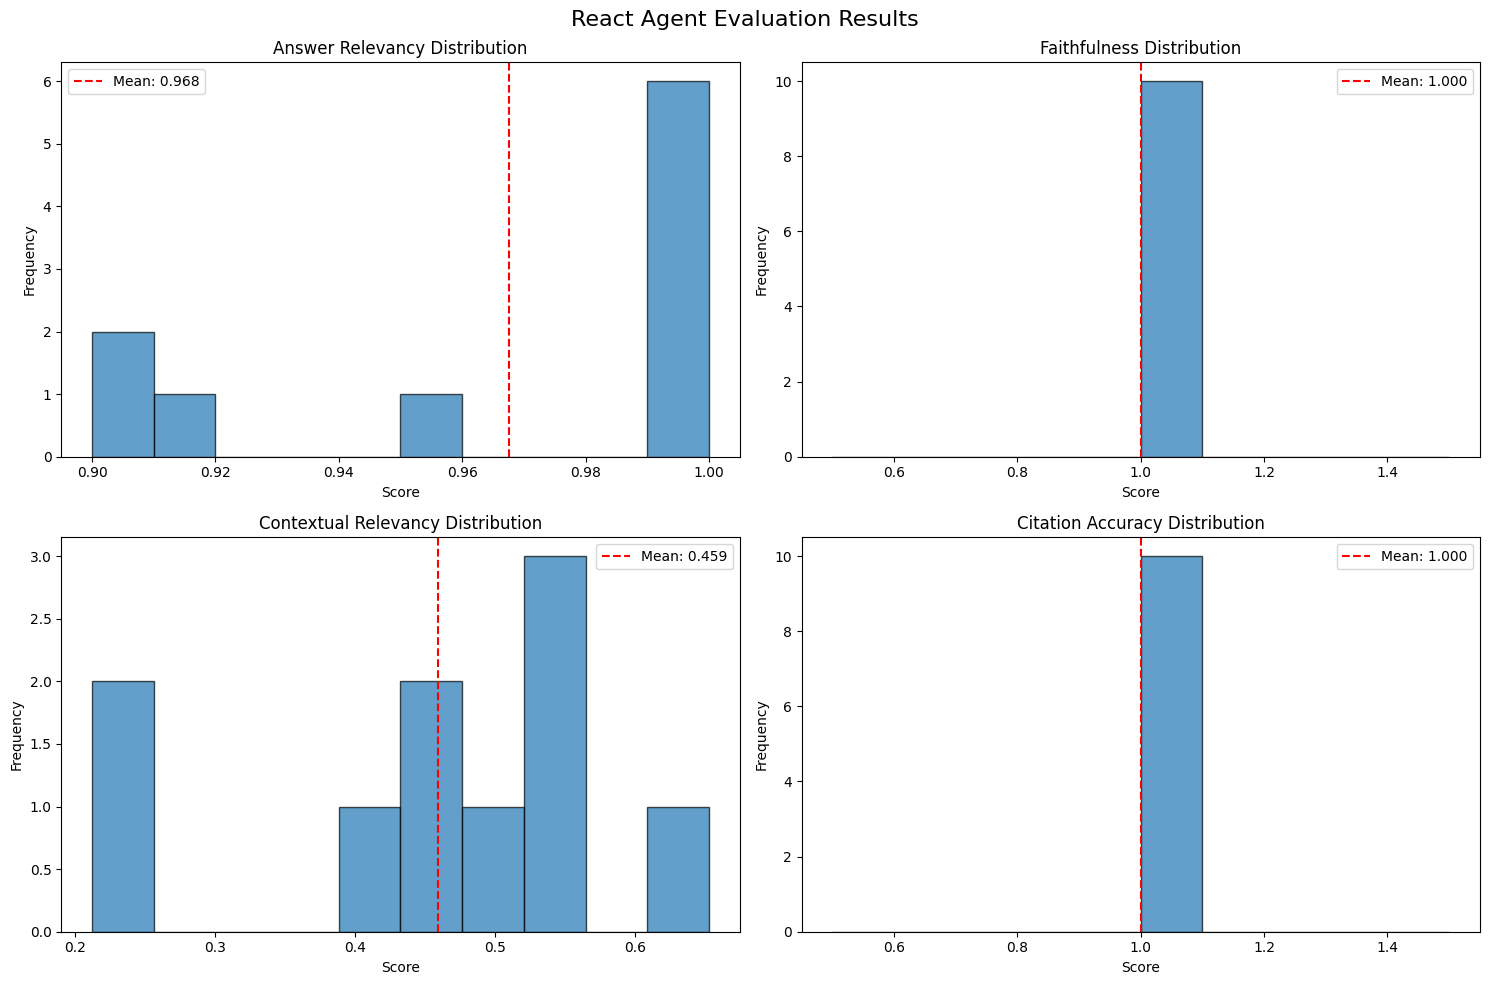

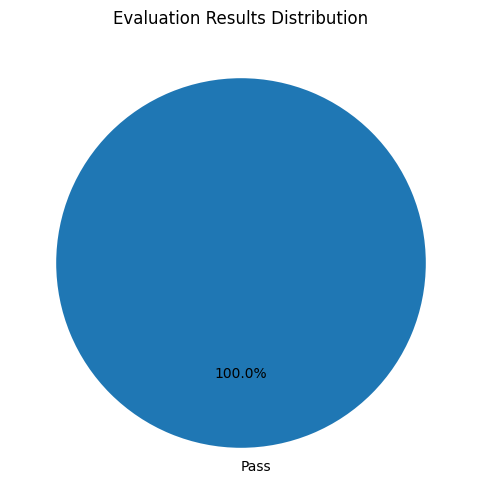

✅ Visualizations saved as PNG files


In [23]:
# Optional: Create visualizations if matplotlib is available
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Set up the plotting style
    plt.style.use('default')
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('React Agent Evaluation Results', fontsize=16)
    
    # Metric scores distribution
    metrics = ['answer_relevancy_score', 'faithfulness_score', 'contextual_relevancy_score', 'citation_accuracy_score']
    metric_names = ['Answer Relevancy', 'Faithfulness', 'Contextual Relevancy', 'Citation Accuracy']
    
    for i, (metric, name) in enumerate(zip(metrics, metric_names)):
        ax = axes[i//2, i%2]
        ax.hist(results_df[metric], bins=10, alpha=0.7, edgecolor='black')
        ax.set_title(f'{name} Distribution')
        ax.set_xlabel('Score')
        ax.set_ylabel('Frequency')
        ax.axvline(results_df[metric].mean(), color='red', linestyle='--', label=f'Mean: {results_df[metric].mean():.3f}')
        ax.legend()
    
    plt.tight_layout()
    plt.savefig('evaluation_results_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Correctness pie chart
    plt.figure(figsize=(8, 6))
    correctness_counts = results_df['correctness'].value_counts()
    plt.pie(correctness_counts.values, labels=correctness_counts.index, autopct='%1.1f%%', startangle=90)
    plt.title('Evaluation Results Distribution')
    plt.savefig('correctness_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Visualizations saved as PNG files")
    
except ImportError:
    print("📊 Matplotlib not available. Install it for visualizations: pip install matplotlib seaborn")

## Conclusion

This notebook demonstrates a comprehensive evaluation approach for LLM agents using DeepEval. The evaluation covers:

1. **Answer Quality**: Using DeepEval's built-in metrics (Answer Relevancy, Faithfulness, Contextual Relevancy)
2. **Citation Accuracy**: Custom evaluation of whether the agent provides proper citations
3. **Systematic Testing**: Batch evaluation of multiple questions from CSV/Excel files
4. **Results Export**: Saving detailed results back to Excel for further analysis

### Key Features:
- **Automated Evaluation**: No manual scoring required
- **Multiple Metrics**: Comprehensive assessment across different dimensions
- **Reproducible**: Can be run multiple times with consistent results
- **Extensible**: Easy to add new questions or modify evaluation criteria

### Next Steps:
1. Analyze the results to identify areas for improvement
2. Tune the agent's prompt or search parameters based on evaluation findings
3. Add more diverse questions to the evaluation set
4. Implement automated evaluation as part of CI/CD pipeline